In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import os
import numpy as np
import pandas as pd
import math, random
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('whitegrid')
from scipy import stats
import missingno as msno

# display all columns
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_row', None)

In [ ]:
# load data
train_data = pd.read_csv('/content/drive/MyDrive/최종프로젝트/physionet2012_train.csv')
valid_data = pd.read_csv('/content/drive/MyDrive/최종프로젝트/physionet2012_valid.csv')
test_data = pd.read_csv('/content/drive/MyDrive/최종프로젝트/physionet2012_test.csv')

train_data.drop(['Unnamed: 0'], axis=1, inplace=True)
valid_data.drop(['Unnamed: 0'], axis=1, inplace=True)
test_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
# labeling
# train_data
train_data['label'] = 0
train_data.loc[(2 <= train_data['survival'])&(train_data['survival'] <= train_data['LOS']), 'label'] = 1
train_data.loc[train_data['survival'] > train_data['LOS'], 'label'] = 0
train_data.loc[train_data['survival'] == -1, 'label'] = 0

# valid_data
valid_data['label'] = 0
valid_data.loc[(2 <= valid_data['survival'])&(valid_data['survival'] <= valid_data['LOS']), 'label'] = 1
valid_data.loc[valid_data['survival'] > valid_data['LOS'], 'label'] = 0
valid_data.loc[valid_data['survival'] == -1, 'label'] = 0

# test_data
test_data['label'] = 0
test_data.loc[(2 <= test_data['survival'])&(test_data['survival'] <= test_data['LOS']), 'label'] = 1
test_data.loc[test_data['survival'] > test_data['LOS'], 'label'] = 0
test_data.loc[test_data['survival'] == -1, 'label'] = 0

In [ ]:
train_df = train_data.copy()
valid_df = valid_data.copy()
test_df = test_data.copy()

In [ ]:
# ffill
train_df.groupby(['pid']).fillna(method='ffill', inplace=True)
valid_df.groupby(['pid']).fillna(method='ffill', inplace=True)
test_df.groupby(['pid']).fillna(method='ffill', inplace=True)

""


In [ ]:
# median
train_df.fillna(train_df.median(), inplace=True)
valid_df.fillna(valid_df.median(), inplace=True)
test_df.fillna(test_df.median(), inplace=True)

In [ ]:
# Gender -1값 1로 바꾸기
train_df.loc[train_df['Gender']==-1, 'Gender'] = 1 

In [ ]:
train_df.drop(columns=['rec_time', 'Tropl', 'TropT', 'male', 'female', 'survival', 'surv_los', 'LOS'], inplace=True)
valid_df.drop(columns=['rec_time', 'Tropl', 'TropT', 'male', 'female', 'survival', 'surv_los', 'LOS'], inplace=True)
test_df.drop(columns=['rec_time', 'Tropl', 'TropT', 'male', 'female', 'survival', 'surv_los', 'LOS'], inplace=True)

In [ ]:
# train
pad_train_df = pd.DataFrame(columns = train_df.columns)
p = train_df['pid'].unique()
max_len = 70
for ep in p:
    if len(train_df[train_df['pid']==ep]) >= max_len:
        df = train_df[train_df['pid']==ep][:max_len]
        pad_train_df = pd.concat([pad_train_df, df])
    else:
        empty_df = pd.DataFrame(index=range(0,70), columns = train_df.columns) 
        empty_df[['pid']] = ep
        empty_df[['age']] = train_df[train_df['pid']==ep]['age'].values[0]
        empty_df[['Gender']] = train_df[train_df['pid']==ep]['Gender'].values[0]
        empty_df[['ICUType']] = train_df[train_df['pid']==ep]['ICUType'].values[0]
        empty_df[['label']] = train_df[train_df['pid']==ep]['label'].values[0]
        empty_df.iloc[-len(train_df[train_df['pid']==ep]):] = train_df[train_df['pid']==ep]
        empty_df.fillna(0, inplace=True)
        pad_train_df = pd.concat([pad_train_df, empty_df])

# valid
pad_valid_df = pd.DataFrame(columns = valid_df.columns)
p = valid_df['pid'].unique()
max_len = 70
for ep in p:
    if len(valid_df[valid_df['pid']==ep]) >= max_len:
        df = valid_df[valid_df['pid']==ep][:max_len]
        pad_valid_df = pd.concat([pad_valid_df, df])
    else:
        empty_df = pd.DataFrame(index=range(0,70), columns = valid_df.columns) 
        empty_df[['pid']] = ep
        empty_df[['age']] = valid_df[valid_df['pid']==ep]['age'].values[0]
        empty_df[['Gender']] = valid_df[valid_df['pid']==ep]['Gender'].values[0]
        empty_df[['ICUType']] = valid_df[valid_df['pid']==ep]['ICUType'].values[0]
        empty_df[['label']] = valid_df[valid_df['pid']==ep]['label'].values[0]
        empty_df.iloc[-len(valid_df[valid_df['pid']==ep]):] = valid_df[valid_df['pid']==ep]
        empty_df.fillna(0, inplace=True)
        pad_valid_df = pd.concat([pad_valid_df, empty_df])

# test
pad_test_df = pd.DataFrame(columns = test_df.columns)
p = test_df['pid'].unique()
max_len = 70
for ep in p:
    if len(test_df[test_df['pid']==ep]) >= max_len:
        df = test_df[test_df['pid']==ep][:max_len]
        pad_test_df = pd.concat([pad_test_df, df])
    else:
        empty_df = pd.DataFrame(index=range(0,70), columns = test_df.columns) 
        empty_df[['pid']] = ep
        empty_df[['age']] = test_df[test_df['pid']==ep]['age'].values[0]
        empty_df[['Gender']] = test_df[test_df['pid']==ep]['Gender'].values[0]
        empty_df[['ICUType']] = test_df[test_df['pid']==ep]['ICUType'].values[0]
        empty_df[['label']] = test_df[test_df['pid']==ep]['label'].values[0]
        empty_df.iloc[-len(test_df[test_df['pid']==ep]):] = test_df[test_df['pid']==ep]
        empty_df.fillna(0, inplace=True)
        pad_test_df = pd.concat([pad_test_df, empty_df])

In [ ]:
ohe_train_df = pd.get_dummies(pad_train_df, columns=['Gender', 'ICUType', 'MechVent'])
ohe_valid_df = pd.get_dummies(pad_valid_df, columns=['Gender', 'ICUType', 'MechVent'])
ohe_test_df = pd.get_dummies(pad_test_df, columns=['Gender', 'ICUType', 'MechVent'])

In [ ]:
ohe_train_df = ohe_train_df.astype('float')
ohe_valid_df = ohe_valid_df.astype('float')
ohe_test_df = ohe_test_df.astype('float')

In [ ]:
ordinary_train = ohe_train_df.copy()
ordinary_valid = ohe_valid_df.copy()
ordinary_test = ohe_test_df.copy()

In [ ]:
ordinary_train.drop(columns=['pid', 'label'], axis=1, inplace=True)
ordinary_valid.drop(columns=['pid', 'label'], axis=1, inplace=True)
ordinary_test.drop(columns=['pid', 'label'], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(ordinary_train)
scaled_train = scaler.transform(ordinary_train)
scaled_valid = scaler.transform(ordinary_valid)
scaled_test = scaler.transform(ordinary_test)
# scaled_train_df = pd.DataFrame(data=scaled_train, columns=ordinary_train.feature_names)

In [ ]:
# splitting dataset
train_X = scaled_train
train_y = ohe_train_df['label']

valid_X = scaled_valid
valid_y = ohe_valid_df['label']

test_X = scaled_test
test_y = ohe_test_df['label']

In [ ]:
print(train_X.shape, train_y.shape)

(226800, 41) (226800,)


In [ ]:
# imbalanced-learn 패키지
from imblearn.over_sampling import *
from imblearn.over_sampling import SMOTE

# 검증 데이터나 테스트 데이터가 아닌 학습데이터에서만 오버샘플링 사용할 것
# smote = SMOTE(random_state=0)
train_X_over, train_y_over = SMOTE(random_state=0).fit_resample(train_X, train_y)

In [ ]:
# reshape
print(train_X_over.shape, train_y_over.shape)
print(valid_X.shape, valid_y.shape)
print(test_X.shape, test_y.shape)

train_X_3d = train_X_over.reshape(-1, max_len, train_X_over.shape[-1])
train_y_3d = train_y_over[::70]
valid_X_3d = valid_X.reshape(-1, max_len, valid_X.shape[-1])
valid_y_3d = valid_y[::70]
test_X_3d = test_X.reshape(-1, max_len, test_X.shape[-1])
test_y_3d = test_y[::70]

print(train_X_3d.shape, train_y_3d.shape)
print(valid_X_3d.shape, valid_y_3d.shape)
print(test_X_3d.shape, test_y_3d.shape)

(393820, 41) (393820,)
(25200, 41) (25200,)
(28000, 41) (28000,)
(5626, 70, 41) (5626,)
(360, 70, 41) (360,)
(400, 70, 41) (400,)


In [ ]:
print(train_X_3d.shape, train_y_3d.shape)

(5626, 70, 41) (5626,)


In [ ]:
# setup
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_auc_score

from keras import layers
from keras import Sequential, Model
# from keras.preprocessing.sequence import pad_sequences
from pprint import pprint

from keras.models import Sequential             
from keras.layers import Dense, Dropout, BatchNormalization, SimpleRNN, LSTM, Bidirectional, BatchNormalization, Activation, GRU, Flatten, Conv1D, GlobalMaxPooling1D
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.optimizers import RMSprop, Adam
from keras import models
from keras import layers
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

In [ ]:
feature_dim = train_X_over.shape[-1]

In [ ]:
import os

model_dir = '/content/drive/MyDrive/최종프로젝트/model3/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

modelpath='/content/drive/MyDrive/최종프로젝트/model3/{epoch:02d}-{val_auroc:.4f}.hdf5'

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=5, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

# **ANN**

In [ ]:
model = Sequential()
model.add(Dense(64, input_shape = (max_len, feature_dim), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
model_history = model.fit(train_X_3d, train_y_3d, epochs=16, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1)
history = model_history.history

Epoch 1/16
113/113 [==============================] - 10s 74ms/step - loss: 0.4579 - auroc: 0.9223 - val_loss: 1.0131 - val_auroc: 0.5709
Epoch 2/16
113/113 [==============================] - 8s 69ms/step - loss: 0.2446 - auroc: 0.9525 - val_loss: 1.8358 - val_auroc: 0.6985
Epoch 3/16
113/113 [==============================] - 8s 69ms/step - loss: 0.2157 - auroc: 0.9579 - val_loss: 1.4158 - val_auroc: 0.6609
Epoch 4/16
113/113 [==============================] - 8s 70ms/step - loss: 0.2034 - auroc: 0.9624 - val_loss: 0.8189 - val_auroc: 0.6804
Epoch 5/16
113/113 [==============================] - 8s 70ms/step - loss: 0.1955 - auroc: 0.9645 - val_loss: 0.4461 - val_auroc: 0.7301
Epoch 6/16
113/113 [==============================] - 9s 82ms/step - loss: 0.1875 - auroc: 0.9681 - val_loss: 0.4134 - val_auroc: 0.7328
Epoch 7/16
113/113 [==============================] - 8s 69ms/step - loss: 0.1824 - auroc: 0.9700 - val_loss: 0.3901 - val_auroc: 0.7311
Epoch 8/16
113/113 [====================

# **RNN**

In [ ]:
# RNN
rnn1_model = Sequential()
rnn1_model.add(SimpleRNN(128, input_shape = (max_len, feature_dim), return_sequences=True, activation="tanh"))
rnn1_model.add(Dropout(0.25)) 
rnn1_model.add(SimpleRNN(64, return_sequences=True, activation="tanh"))
rnn1_model.add(Dropout(0.2)) 
rnn1_model.add(SimpleRNN(32, return_sequences=True, activation="tanh"))
rnn1_model.add(Dropout(0.2)) 
rnn1_model.add(Dense(16, activation='tanh'))
rnn1_model.add(Dense(8, activation='tanh'))
rnn1_model.add(Flatten())
rnn1_model.add(Dense(1, activation='sigmoid'))
rnn1_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
# LSTM
lstm1_model = Sequential()
lstm1_model.add(LSTM(128, input_shape = (max_len, feature_dim), return_sequences=True, activation='tanh'))
lstm1_model.add(Dropout(0.5)) 
lstm1_model.add(LSTM(64, return_sequences=True, activation="tanh"))
lstm1_model.add(Dropout(0.25)) 
lstm1_model.add(LSTM(32, return_sequences=True, activation="tanh"))
lstm1_model.add(Dropout(0.25)) 
lstm1_model.add(LSTM(16, return_sequences=False, activation="tanh"))
lstm1_model.add(Dropout(0.2)) 
lstm1_model.add(Dense(8, activation='tanh'))
lstm1_model.add(Dense(1, activation='sigmoid'))
lstm1_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
# GRU
gru1_model = Sequential()
gru1_model.add(GRU(128, input_shape = (max_len, feature_dim), return_sequences=True, activation='tanh'))
gru1_model.add(Dropout(0.5)) 
gru1_model.add(GRU(64, return_sequences=True, activation="tanh"))
gru1_model.add(Dropout(0.25)) 
gru1_model.add(GRU(32, return_sequences=True, activation="tanh"))
gru1_model.add(Dropout(0.25)) 
gru1_model.add(GRU(16, return_sequences=False, activation="tanh")) 
gru1_model.add(Dropout(0.2)) 
gru1_model.add(Dense(8, activation='tanh'))
gru1_model.add(Dense(1, activation='sigmoid'))
gru1_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
# callbacks=[checkpointer, early_stop]

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

rnn1_model_history = rnn1_model.fit(train_X_3d, train_y_3d, epochs=16, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1)
rnn1_history = rnn1_model_history.history

Epoch 1/16
113/113 [==============================] - 14s 94ms/step - loss: 0.6011 - auroc: 0.7369 - val_loss: 0.5568 - val_auroc: 0.6709
Epoch 2/16
113/113 [==============================] - 11s 96ms/step - loss: 0.4200 - auroc: 0.8786 - val_loss: 0.4544 - val_auroc: 0.6736
Epoch 3/16
113/113 [==============================] - 10s 85ms/step - loss: 0.2618 - auroc: 0.9452 - val_loss: 0.4241 - val_auroc: 0.6547
Epoch 4/16
113/113 [==============================] - 10s 84ms/step - loss: 0.2345 - auroc: 0.9496 - val_loss: 0.4032 - val_auroc: 0.6771
Epoch 5/16
113/113 [==============================] - 10s 85ms/step - loss: 0.2276 - auroc: 0.9496 - val_loss: 0.4021 - val_auroc: 0.6597
Epoch 6/16
113/113 [==============================] - 11s 98ms/step - loss: 0.2280 - auroc: 0.9493 - val_loss: 0.3688 - val_auroc: 0.7077
Epoch 7/16
113/113 [==============================] - 9s 83ms/step - loss: 0.2257 - auroc: 0.9480 - val_loss: 0.3779 - val_auroc: 0.6916
Epoch 8/16
113/113 [===============

In [ ]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

lstm1_model_history = lstm1_model.fit(train_X_3d, train_y_3d, epochs=16, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1)
lstm1_history = lstm1_model_history.history

Epoch 1/16
113/113 [==============================] - 45s 318ms/step - loss: 0.6102 - auroc: 0.7570 - val_loss: 0.4387 - val_auroc: 0.7047
Epoch 2/16
113/113 [==============================] - 32s 279ms/step - loss: 0.3031 - auroc: 0.9307 - val_loss: 0.3964 - val_auroc: 0.6503
Epoch 3/16
113/113 [==============================] - 32s 279ms/step - loss: 0.2712 - auroc: 0.9305 - val_loss: 0.3916 - val_auroc: 0.7074
Epoch 4/16
113/113 [==============================] - 32s 280ms/step - loss: 0.2729 - auroc: 0.9288 - val_loss: 0.3850 - val_auroc: 0.7265
Epoch 5/16
113/113 [==============================] - 32s 281ms/step - loss: 0.2575 - auroc: 0.9341 - val_loss: 0.3763 - val_auroc: 0.7303
Epoch 6/16
113/113 [==============================] - 32s 282ms/step - loss: 0.2502 - auroc: 0.9390 - val_loss: 0.3742 - val_auroc: 0.7281
Epoch 7/16
113/113 [==============================] - 32s 280ms/step - loss: 0.2441 - auroc: 0.9439 - val_loss: 0.3776 - val_auroc: 0.7203
Epoch 8/16
113/113 [=======

In [ ]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

gru1_model_history = gru1_model.fit(train_X_3d, train_y_3d, epochs=16, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1)
gru1_history = gru1_model_history.history

Epoch 1/16
113/113 [==============================] - 60s 451ms/step - loss: 0.6780 - auroc: 0.6183 - val_loss: 0.6069 - val_auroc: 0.7339
Epoch 2/16
113/113 [==============================] - 32s 286ms/step - loss: 0.5875 - auroc: 0.7700 - val_loss: 0.5676 - val_auroc: 0.7424
Epoch 3/16
113/113 [==============================] - 27s 234ms/step - loss: 0.4228 - auroc: 0.8838 - val_loss: 0.4826 - val_auroc: 0.6931
Epoch 4/16
113/113 [==============================] - 28s 244ms/step - loss: 0.3420 - auroc: 0.9235 - val_loss: 0.4344 - val_auroc: 0.6738
Epoch 5/16
113/113 [==============================] - 26s 230ms/step - loss: 0.2953 - auroc: 0.9357 - val_loss: 0.4325 - val_auroc: 0.7136
Epoch 6/16
113/113 [==============================] - 26s 230ms/step - loss: 0.2828 - auroc: 0.9369 - val_loss: 0.4357 - val_auroc: 0.7054
Epoch 7/16
113/113 [==============================] - 28s 246ms/step - loss: 0.2728 - auroc: 0.9399 - val_loss: 0.4395 - val_auroc: 0.7130
Epoch 8/16
113/113 [=======

# **RNN (Bidirectional, tanh)**

In [ ]:
# RNN
rnn2_model = Sequential()
rnn2_model.add(SimpleRNN(128, input_shape = (max_len, feature_dim), return_sequences=True, activation='tanh'))
rnn2_model.add(Dropout(0.5)) 
rnn2_model.add(SimpleRNN(256, return_sequences=True, activation="tanh"))
rnn2_model.add(Dropout(0.25)) 
rnn2_model.add(SimpleRNN(128, return_sequences=True, activation="tanh"))
rnn2_model.add(Dropout(0.25)) 
rnn2_model.add(SimpleRNN(64, return_sequences=True, activation="tanh"))
rnn2_model.add(Dropout(0.2)) 
rnn2_model.add(SimpleRNN(32, return_sequences=True, activation="tanh"))
rnn2_model.add(Dropout(0.2)) 
rnn2_model.add(Flatten())
rnn2_model.add(Dense(16, activation='tanh'))
rnn2_model.add(Dense(1, activation='sigmoid'))
rnn2_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
# LSTM
lstm2_model = Sequential()
lstm2_model.add(Bidirectional(LSTM(128, input_shape = (max_len, feature_dim), return_sequences=True, activation='tanh')))
lstm2_model.add(Dropout(0.5)) 
lstm2_model.add(Bidirectional(LSTM(256, return_sequences=True, activation="tanh")))
lstm2_model.add(Dropout(0.25)) 
lstm2_model.add(Bidirectional(LSTM(128, return_sequences=True, activation="tanh")))
lstm2_model.add(Dropout(0.25)) 
lstm2_model.add(Bidirectional(LSTM(64, return_sequences=True, activation="tanh")))
lstm2_model.add(Dropout(0.2)) 
lstm2_model.add(Bidirectional(LSTM(32, return_sequences=False, activation="tanh")))
lstm2_model.add(Dropout(0.2)) 
lstm2_model.add(Dense(16, activation='tanh'))
lstm2_model.add(Dense(1, activation='sigmoid'))
lstm2_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
# GRU
gru2_model = Sequential()
gru2_model.add(Bidirectional(GRU(128, input_shape = (max_len, feature_dim), return_sequences=True, activation='tanh')))
gru2_model.add(Dropout(0.5)) 
gru2_model.add(Bidirectional(GRU(256, return_sequences=True, activation="tanh")))
gru2_model.add(Dropout(0.25)) 
gru2_model.add(Bidirectional(GRU(128, return_sequences=True, activation="tanh")))
gru2_model.add(Dropout(0.25)) 
gru2_model.add(Bidirectional(GRU(64, return_sequences=True, activation="tanh"))) 
gru2_model.add(Dropout(0.2)) 
gru2_model.add(Bidirectional(GRU(32, return_sequences=False, activation="tanh"))) 
gru2_model.add(Dropout(0.2)) 
gru2_model.add(Dense(16, activation='tanh'))
gru2_model.add(Dense(1, activation='sigmoid'))
gru2_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

rnn2_model_history = rnn2_model.fit(train_X_3d, train_y_3d, epochs=16, batch_size=50, validation_data=(valid_X_3d, valid_y_3d))
rnn2_history = rnn2_model_history.history

Epoch 1/16
113/113 [==============================] - 40s 296ms/step - loss: 0.6178 - auroc: 0.7166 - val_loss: 0.7989 - val_auroc: 0.6565
Epoch 2/16
113/113 [==============================] - 32s 287ms/step - loss: 0.4476 - auroc: 0.8467 - val_loss: 0.5574 - val_auroc: 0.6805
Epoch 3/16
113/113 [==============================] - 33s 289ms/step - loss: 0.2938 - auroc: 0.9431 - val_loss: 0.4264 - val_auroc: 0.6497
Epoch 4/16
113/113 [==============================] - 35s 307ms/step - loss: 0.2296 - auroc: 0.9493 - val_loss: 0.4304 - val_auroc: 0.6861
Epoch 5/16
113/113 [==============================] - 33s 289ms/step - loss: 0.2347 - auroc: 0.9443 - val_loss: 0.3850 - val_auroc: 0.6999
Epoch 6/16
113/113 [==============================] - 32s 287ms/step - loss: 0.2242 - auroc: 0.9487 - val_loss: 0.3872 - val_auroc: 0.7144
Epoch 7/16
113/113 [==============================] - 32s 284ms/step - loss: 0.2229 - auroc: 0.9497 - val_loss: 0.3700 - val_auroc: 0.6678
Epoch 8/16
113/113 [=======

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=5, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

lstm2_model_history = lstm2_model.fit(train_X_3d, train_y_3d, epochs=16, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1)
lstm2_history = lstm2_model_history.history

Epoch 1/16
113/113 [==============================] - 255s 2s/step - loss: 0.4370 - auroc: 0.8908 - val_loss: 0.3786 - val_auroc: 0.6977
Epoch 2/16
113/113 [==============================] - 223s 2s/step - loss: 0.2352 - auroc: 0.9470 - val_loss: 0.3633 - val_auroc: 0.7163
Epoch 3/16
113/113 [==============================] - 221s 2s/step - loss: 0.2341 - auroc: 0.9475 - val_loss: 0.3661 - val_auroc: 0.7132
Epoch 4/16
113/113 [==============================] - 221s 2s/step - loss: 0.2200 - auroc: 0.9522 - val_loss: 0.3701 - val_auroc: 0.7078
Epoch 5/16
113/113 [==============================] - 221s 2s/step - loss: 0.2176 - auroc: 0.9532 - val_loss: 0.3699 - val_auroc: 0.7035
Epoch 6/16
113/113 [==============================] - 220s 2s/step - loss: 0.2173 - auroc: 0.9525 - val_loss: 0.3634 - val_auroc: 0.7093
Epoch 7/16
113/113 [==============================] - 220s 2s/step - loss: 0.2141 - auroc: 0.9547 - val_loss: 0.3594 - val_auroc: 0.7306
Epoch 8/16
113/113 [=====================

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

gru2_model_history = gru2_model.fit(train_X_3d, train_y_3d, epochs=16, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1)
gru2_history = gru2_model_history.history 

Epoch 1/16
113/113 [==============================] - 210s 2s/step - loss: 0.5339 - auroc: 0.8020 - val_loss: 0.6150 - val_auroc: 0.6952
Epoch 2/16
113/113 [==============================] - 181s 2s/step - loss: 0.3817 - auroc: 0.9143 - val_loss: 0.4759 - val_auroc: 0.7418
Epoch 3/16
113/113 [==============================] - 176s 2s/step - loss: 0.2473 - auroc: 0.9471 - val_loss: 0.3771 - val_auroc: 0.6874
Epoch 4/16
113/113 [==============================] - 179s 2s/step - loss: 0.2303 - auroc: 0.9485 - val_loss: 0.3645 - val_auroc: 0.7181
Epoch 5/16
113/113 [==============================] - 178s 2s/step - loss: 0.2211 - auroc: 0.9524 - val_loss: 0.3610 - val_auroc: 0.7475
Epoch 6/16
113/113 [==============================] - 179s 2s/step - loss: 0.2272 - auroc: 0.9494 - val_loss: 0.3641 - val_auroc: 0.7225
Epoch 7/16
113/113 [==============================] - 176s 2s/step - loss: 0.2221 - auroc: 0.9513 - val_loss: 0.3464 - val_auroc: 0.7536
Epoch 8/16
113/113 [=====================

# **CNN**

In [ ]:
# cnn1
cnn1_model = Sequential()
cnn1_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(max_len, feature_dim)))
cnn1_model.add(Dropout(0.5))
cnn1_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn1_model.add(Dropout(0.25))
cnn1_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn1_model.add(Dropout(0.2))
cnn1_model.add(Flatten())
cnn1_model.add(Dense(32, activation='relu'))
cnn1_model.add(Dropout(0.2))
cnn1_model.add(Dense(16, activation='relu'))
cnn1_model.add(Dropout(0.25))
cnn1_model.add(Dense(8, activation='relu'))
cnn1_model.add(Dense(1, activation='sigmoid'))
cnn1_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
# cnn2(maxpooling)
cnn2_model = Sequential()
cnn2_model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(max_len, feature_dim)))
cnn2_model.add(MaxPooling1D())
cnn2_model.add(Conv1D(64, kernel_size=5, activation='relu'))
cnn2_model.add(MaxPooling1D())
cnn2_model.add(layers.Conv1D(32, kernel_size=5, activation='relu'))
cnn2_model.add(MaxPooling1D())
cnn2_model.add(layers.Conv1D(16, kernel_size=5, activation='relu'))
cnn2_model.add(GlobalMaxPooling1D())
cnn2_model.add(Dense(16, activation='relu'))
cnn2_model.add(BatchNormalization())
cnn2_model.add(Dropout(0.2))
cnn2_model.add(Dense(1, activation='sigmoid'))
cnn2_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
# cnn3(gru)
cnn3_model = Sequential()
cnn3_model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(max_len, feature_dim)))
cnn3_model.add(MaxPooling1D())
cnn3_model.add(Conv1D(32, kernel_size=5, activation='relu'))
cnn3_model.add(GRU(32, dropout=0.1, recurrent_dropout=0.25, activation='tanh'))
cnn3_model.add(Dense(16, activation='relu'))
cnn3_model.add(BatchNormalization())
cnn3_model.add(Dropout(0.2))
cnn3_model.add(Dense(8, activation='relu'))
cnn3_model.add(Dense(1, activation='sigmoid'))
cnn3_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
# cnn4(lstm)
cnn4_model = Sequential()
cnn4_model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(max_len, feature_dim)))
cnn4_model.add(MaxPooling1D())
cnn4_model.add(Conv1D(32, kernel_size=5, activation='relu'))
cnn4_model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.25, activation='tanh'))
cnn4_model.add(Dense(16, activation='relu'))
cnn4_model.add(BatchNormalization())
cnn4_model.add(Dropout(0.2))
cnn4_model.add(Dense(8, activation='relu'))
cnn4_model.add(Dense(1, activation='sigmoid'))
cnn4_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=12, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

cnn1_model_history = cnn1_model.fit(train_X_3d, train_y_3d, epochs=20, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1)
cnn1_history = cnn1_model_history.history

Epoch 1/20
113/113 [==============================] - 7s 48ms/step - loss: 0.6917 - auroc: 0.5334 - val_loss: 0.6787 - val_auroc: 0.5786
Epoch 2/20
113/113 [==============================] - 5s 45ms/step - loss: 0.6690 - auroc: 0.6394 - val_loss: 0.6855 - val_auroc: 0.6480
Epoch 3/20
113/113 [==============================] - 5s 44ms/step - loss: 0.5716 - auroc: 0.7801 - val_loss: 0.5430 - val_auroc: 0.7006
Epoch 4/20
113/113 [==============================] - 5s 44ms/step - loss: 0.3797 - auroc: 0.9155 - val_loss: 0.3757 - val_auroc: 0.6935
Epoch 5/20
113/113 [==============================] - 5s 44ms/step - loss: 0.2705 - auroc: 0.9415 - val_loss: 0.3625 - val_auroc: 0.7345
Epoch 6/20
113/113 [==============================] - 5s 44ms/step - loss: 0.2587 - auroc: 0.9385 - val_loss: 0.3543 - val_auroc: 0.7518
Epoch 7/20
113/113 [==============================] - 5s 44ms/step - loss: 0.2446 - auroc: 0.9422 - val_loss: 0.3527 - val_auroc: 0.7543
Epoch 8/20
113/113 [=====================

In [ ]:
cnn2_model_history = cnn2_model.fit(train_X_3d, train_y_3d, epochs=20, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1)
cnn2_history = cnn2_model_history.history

Epoch 1/20
113/113 [==============================] - 8s 60ms/step - loss: 0.4741 - auroc: 0.8618 - val_loss: 0.5973 - val_auroc: 0.6760
Epoch 2/20
113/113 [==============================] - 4s 39ms/step - loss: 0.2770 - auroc: 0.9446 - val_loss: 0.5446 - val_auroc: 0.6865
Epoch 3/20
113/113 [==============================] - 4s 34ms/step - loss: 0.2527 - auroc: 0.9469 - val_loss: 0.4459 - val_auroc: 0.7201
Epoch 4/20
113/113 [==============================] - 4s 34ms/step - loss: 0.2384 - auroc: 0.9520 - val_loss: 0.3749 - val_auroc: 0.7356
Epoch 5/20
113/113 [==============================] - 4s 34ms/step - loss: 0.2388 - auroc: 0.9508 - val_loss: 0.3484 - val_auroc: 0.7558
Epoch 6/20
113/113 [==============================] - 4s 34ms/step - loss: 0.2389 - auroc: 0.9511 - val_loss: 0.4112 - val_auroc: 0.7249
Epoch 7/20
113/113 [==============================] - 4s 34ms/step - loss: 0.2324 - auroc: 0.9531 - val_loss: 0.3821 - val_auroc: 0.7156
Epoch 8/20
113/113 [=====================

In [ ]:
cnn3_model_history = cnn3_model.fit(train_X_3d, train_y_3d, epochs=20, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1)
cnn3_history = cnn3_model_history.history

Epoch 1/20
113/113 [==============================] - 9s 51ms/step - loss: 0.4704 - auroc: 0.9140 - val_loss: 0.6424 - val_auroc: 0.6329
Epoch 2/20
113/113 [==============================] - 5s 45ms/step - loss: 0.3643 - auroc: 0.9398 - val_loss: 0.5522 - val_auroc: 0.7220
Epoch 3/20
113/113 [==============================] - 5s 46ms/step - loss: 0.3167 - auroc: 0.9489 - val_loss: 0.4471 - val_auroc: 0.7319
Epoch 4/20
113/113 [==============================] - 5s 46ms/step - loss: 0.2930 - auroc: 0.9473 - val_loss: 0.3853 - val_auroc: 0.7179
Epoch 5/20
113/113 [==============================] - 5s 46ms/step - loss: 0.2672 - auroc: 0.9495 - val_loss: 0.3633 - val_auroc: 0.7364
Epoch 6/20
113/113 [==============================] - 5s 45ms/step - loss: 0.2495 - auroc: 0.9538 - val_loss: 0.3634 - val_auroc: 0.7865
Epoch 7/20
113/113 [==============================] - 5s 45ms/step - loss: 0.2414 - auroc: 0.9541 - val_loss: 0.3421 - val_auroc: 0.7667
Epoch 8/20
113/113 [=====================

In [ ]:
cnn4_model_history = cnn4_model.fit(train_X_3d, train_y_3d, epochs=20, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1)
cnn4_history = cnn4_model_history.history

Epoch 1/20
113/113 [==============================] - 10s 55ms/step - loss: 0.4861 - auroc: 0.8832 - val_loss: 0.6407 - val_auroc: 0.6567
Epoch 2/20
113/113 [==============================] - 7s 59ms/step - loss: 0.2869 - auroc: 0.9418 - val_loss: 0.5696 - val_auroc: 0.7364
Epoch 3/20
113/113 [==============================] - 7s 61ms/step - loss: 0.2493 - auroc: 0.9465 - val_loss: 0.4363 - val_auroc: 0.7562
Epoch 4/20
113/113 [==============================] - 8s 71ms/step - loss: 0.2368 - auroc: 0.9477 - val_loss: 0.4683 - val_auroc: 0.7874
Epoch 5/20
113/113 [==============================] - 6s 54ms/step - loss: 0.2242 - auroc: 0.9533 - val_loss: 0.3769 - val_auroc: 0.7420
Epoch 6/20
113/113 [==============================] - 7s 64ms/step - loss: 0.2243 - auroc: 0.9524 - val_loss: 0.3435 - val_auroc: 0.7863
Epoch 7/20
113/113 [==============================] - 6s 51ms/step - loss: 0.2205 - auroc: 0.9526 - val_loss: 0.3440 - val_auroc: 0.8089
Epoch 8/20
113/113 [====================

# **Functional API**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop = EarlyStopping(monitor='val_auroc', mode='max', patience=12, verbose=1)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_auroc', verbose=1, mode='max', save_best_only=True)

input_layer = tf.keras.Input(shape=(max_len, feature_dim), name='InputLayer')
x1 = tf.keras.layers.Flatten(name='Flatten')(input_layer)
x2 = tf.keras.layers.Dense(256, activation='relu', name='Dense1')(x1)
x3 = tf.keras.layers.Dense(128, activation='relu', name='Dense2')(x2)
x4 = tf.keras.layers.Dense(64, activation='relu', name='Dense3')(x3)
x5 = tf.keras.layers.Dense(32, activation='relu', name='Dense4')(x4)
x6 = tf.keras.layers.Dense(16, activation='relu', name='Dense5')(x5)
x7 = tf.keras.layers.Dense(8, activation='relu', name='Dense6')(x6)
x8 = tf.keras.layers.Dense(1, activation='sigmoid', name='OutputLayer')(x7)

func_model = tf.keras.Model(inputs=input_layer, outputs=x8, name='FunctionalModel')

func_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve="ROC", name='auroc')])

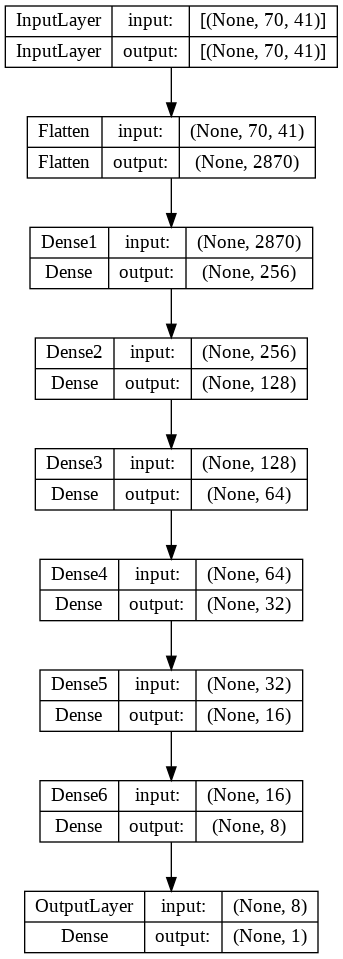

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(func_model, show_shapes=True, show_layer_names=True)

In [ ]:
func_model_history = func_model.fit(train_X_3d, train_y_3d, epochs=20, batch_size=50, validation_data=(valid_X_3d, valid_y_3d), verbose=1)
func_history = func_model_history.history

Epoch 1/20
113/113 [==============================] - 3s 14ms/step - loss: 0.4380 - auroc: 0.9070 - val_loss: 0.4256 - val_auroc: 0.7013
Epoch 2/20
113/113 [==============================] - 1s 11ms/step - loss: 0.2521 - auroc: 0.9509 - val_loss: 0.3729 - val_auroc: 0.7052
Epoch 3/20
113/113 [==============================] - 1s 11ms/step - loss: 0.2226 - auroc: 0.9528 - val_loss: 0.3771 - val_auroc: 0.7251
Epoch 4/20
113/113 [==============================] - 1s 11ms/step - loss: 0.2144 - auroc: 0.9548 - val_loss: 0.3723 - val_auroc: 0.7083
Epoch 5/20
113/113 [==============================] - 1s 11ms/step - loss: 0.2124 - auroc: 0.9551 - val_loss: 0.3593 - val_auroc: 0.7278
Epoch 6/20
113/113 [==============================] - 1s 11ms/step - loss: 0.2096 - auroc: 0.9544 - val_loss: 0.3625 - val_auroc: 0.7228
Epoch 7/20
113/113 [==============================] - 1s 11ms/step - loss: 0.2105 - auroc: 0.9547 - val_loss: 0.3602 - val_auroc: 0.7240
Epoch 8/20
113/113 [=====================

# **Light GBM**

In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

lgbm_model=LGBMClassifier(n_estimators=700)
lgbm_model.fit(train_X_over, train_y_over, early_stopping_rounds=100, eval_metric="auc", eval_set=(valid_X, valid_y), verbose=True)
lgbm_pred=lgbm_model.predict(test_X)


[1]	valid_0's binary_logloss: 0.676215	valid_0's auc: 0.654795
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.663157	valid_0's auc: 0.654038
[3]	valid_0's binary_logloss: 0.652128	valid_0's auc: 0.658145
[4]	valid_0's binary_logloss: 0.642454	valid_0's auc: 0.666981
[5]	valid_0's binary_logloss: 0.633427	valid_0's auc: 0.668535
[6]	valid_0's binary_logloss: 0.625944	valid_0's auc: 0.671313
[7]	valid_0's binary_logloss: 0.620676	valid_0's auc: 0.671568
[8]	valid_0's binary_logloss: 0.614111	valid_0's auc: 0.6759
[9]	valid_0's binary_logloss: 0.605807	valid_0's auc: 0.683623
[10]	valid_0's binary_logloss: 0.599538	valid_0's auc: 0.68175
[11]	valid_0's binary_logloss: 0.59406	valid_0's auc: 0.693127
[12]	valid_0's binary_logloss: 0.589579	valid_0's auc: 0.698772
[13]	valid_0's binary_logloss: 0.586328	valid_0's auc: 0.703835
[14]	valid_0's binary_logloss: 0.581241	valid_0's auc: 0.702023
[15]	valid_0's binary_logloss: 0.578138	valid_0's auc:

In [ ]:
# AUC
auc_score = roc_auc_score(test_y, lgbm_pred)
print(auc_score)

0.6005210306934444


In [ ]:
import lightgbm as lgb

train = lgb.Dataset(train_X_over, label=train_y_over)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'auc'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, train, 100)

# AUC
auc = roc_auc_score(test_y, pred_y)
print(auc)

0.692148659530125


In [ ]:
import lightgbm as lgb

lgb_clf = lgb.LGBMClassifier(num_leaves=31, objective='binary')
lgb_clf.fit(train_X_over, train_y_over)
y_pred = lgb_clf.predict(test_X)
print(roc_auc_score(test_y, pred_y))

0.692148659530125


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

lgbm = LGBMClassifier(n_estimators=200)

params = {'max_depth': [10, 15, 20],
          'min_child_samples': [20, 40, 60],
          'subsample': [0.8, 1],
          'boosting': ['gbdt', 'rf']}

grid = GridSearchCV(lgbm, param_grid=params)
grid.fit(train_X_over, train_y_over, early_stopping_rounds=100, eval_metric='auc', eval_set=[(valid_X, valid_y)])

print("최적 파라미터: ", grid.best_params_)

lgbm_roc_score = roc_auc_score(test_y, grid.predict_proba(test_X)[:, 1], average='macro')
print("ROC AUC: {0:.4f}".format(lgbm_roc_score))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[42]	valid_0's binary_logloss: 0.508432	valid_0's auc: 0.711063
[43]	valid_0's binary_logloss: 0.518504	valid_0's auc: 0.711445
[44]	valid_0's binary_logloss: 0.515091	valid_0's auc: 0.712606
[45]	valid_0's binary_logloss: 0.513139	valid_0's auc: 0.71354
[46]	valid_0's binary_logloss: 0.508894	valid_0's auc: 0.713522
[47]	valid_0's binary_logloss: 0.514551	valid_0's auc: 0.712628
[48]	valid_0's binary_logloss: 0.51266	valid_0's auc: 0.713296
[49]	valid_0's binary_logloss: 0.522858	valid_0's auc: 0.713531
[50]	valid_0's binary_logloss: 0.522404	valid_0's auc: 0.712782
[51]	valid_0's binary_logloss: 0.520439	valid_0's auc: 0.712658
[52]	valid_0's binary_logloss: 0.519489	valid_0's auc: 0.712113
[53]	valid_0's binary_logloss: 0.518293	valid_0's auc: 0.712037
[54]	valid_0's binary_logloss: 0.517625	valid_0's auc: 0.712383
[55]	valid_0's binary_logloss: 0.515676	valid_0's auc: 0.713638
[56]	valid_0's binary_logloss: 0.535702	valid_0's auc: 0.711779
[57]	v

> 최적 파라미터:  {'boosting': 'gbdt', 'max_depth': 15, 'min_child_samples': 40, 'subsample': 0.8}<br>
ROC AUC: 0.7124

In [ ]:
# 결과 적용
lgbm = LGBMClassifier(n_estimators=1000, num_leaves=50, subsample=0.8, min_child_samples=40, max_depth=15)
lgbm.fit(train_X_over, train_y_over, early_stopping_rounds=100, eval_metric='auc', eval_set=(valid_X, valid_y), verbose=True)
lgbm_pred = lgbm.predict_proba(test_X)[:, 1]
score = roc_auc_score(test_y, lgbm_pred, average='macro')
print("ROC AUC: {0:.4f}".format(score))

[1]	valid_0's binary_logloss: 0.674785	valid_0's auc: 0.642156
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.660305	valid_0's auc: 0.648674
[3]	valid_0's binary_logloss: 0.646994	valid_0's auc: 0.663842
[4]	valid_0's binary_logloss: 0.636197	valid_0's auc: 0.666316
[5]	valid_0's binary_logloss: 0.625947	valid_0's auc: 0.673028
[6]	valid_0's binary_logloss: 0.6176	valid_0's auc: 0.677527
[7]	valid_0's binary_logloss: 0.610675	valid_0's auc: 0.678516
[8]	valid_0's binary_logloss: 0.604576	valid_0's auc: 0.681003
[9]	valid_0's binary_logloss: 0.598478	valid_0's auc: 0.686495
[10]	valid_0's binary_logloss: 0.592343	valid_0's auc: 0.689099
[11]	valid_0's binary_logloss: 0.585816	valid_0's auc: 0.691138
[12]	valid_0's binary_logloss: 0.579802	valid_0's auc: 0.694087
[13]	valid_0's binary_logloss: 0.576888	valid_0's auc: 0.695065
[14]	valid_0's binary_logloss: 0.572565	valid_0's auc: 0.698846
[15]	valid_0's binary_logloss: 0.567044	valid_0's au

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print('LGBMClassifier')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
lgbm_clf.fit(train_X_over, train_y_over)
lgbm_pred = lgbm_clf.predict(test_X)
lgbm_pred_proba = lgbm_clf.predict_proba(test_X)[:,1]
print('roc auc score :', roc_auc_score(test_y, lgbm_pred_proba))

# **AUROC**

In [ ]:
# save model
model.save('/content/drive/MyDrive/최종프로젝트/model3/ann_model_e16.h5')

rnn1_model.save('/content/drive/MyDrive/최종프로젝트/model3/rnn1_model_e16.h5')
lstm1_model.save('/content/drive/MyDrive/최종프로젝트/model3/lstm1_model_e16.h5')
gru1_model.save('/content/drive/MyDrive/최종프로젝트/model3/gru1_model_e16.h5')

rnn2_model.save('/content/drive/MyDrive/최종프로젝트/model3/rnn2_model_e16.h5')
lstm2_model.save('/content/drive/MyDrive/최종프로젝트/model3/lstm2_model_e16.h5')
gru2_model.save('/content/drive/MyDrive/최종프로젝트/model3/gru2_model_e16.h5')

cnn1_model.save('/content/drive/MyDrive/최종프로젝트/model3/cnn1_model_e20.h5')
cnn2_model.save('/content/drive/MyDrive/최종프로젝트/model3/cnn2_model_e20.h5')
cnn3_model.save('/content/drive/MyDrive/최종프로젝트/model3/cnn3_model_e20.h5')
cnn4_model.save('/content/drive/MyDrive/최종프로젝트/model3/cnn4_model_e20.h5')

func_model.save('/content/drive/MyDrive/최종프로젝트/model3/func_model_e20.h5')

import joblib

joblib.dump(lgbm,'/content/drive/MyDrive/최종프로젝트/model3/lgbm_model.pkl')

['/content/drive/MyDrive/최종프로젝트/model3/lgbm_model.pkl']

In [ ]:
# load model
from keras.models import load_model
loaded_ann_model = load_model('/content/drive/MyDrive/최종프로젝트/model3/ann-11-0.7739.hdf5')

loaded_rnn1_model = load_model('/content/drive/MyDrive/최종프로젝트/model3/rnn1-22-0.7499.hdf5')
loaded_lstm1_model = load_model('/content/drive/MyDrive/최종프로젝트/model3/lstm1-19-0.7664.hdf5')
loaded_gru1_model = load_model('/content/drive/MyDrive/최종프로젝트/model3/gru1-41-0.8008.hdf5')

loaded_rnn2_model = load_model('/content/drive/MyDrive/최종프로젝트/model3/rnn2-22-0.7602.hdf5')
loaded_lstm2_model = load_model('/content/drive/MyDrive/최종프로젝트/model3/lstm2-14-0.7724.hdf5')
loaded_gru2_model = load_model('/content/drive/MyDrive/최종프로젝트/model3/gru2-25-0.7923.hdf5')

loaded_cnn1_model = load_model('/content/drive/MyDrive/최종프로젝트/model3/cnn1-41-0.8000.hdf5')
loaded_cnn2_model = load_model('/content/drive/MyDrive/최종프로젝트/model3/cnn2-26-0.8025.hdf5')
loaded_cnn3_model = load_model('/content/drive/MyDrive/최종프로젝트/model3/cnn3-07-0.8235.hdf5')
loaded_cnn4_model = load_model('/content/drive/MyDrive/최종프로젝트/model3/cnn4-13-0.8033.hdf5')

# loaded_func_model = load_model('/content/drive/MyDrive/최종프로젝트/model3/func_model_e20.h5')

# loaded_lgbm_model = joblib.load('/content/drive/MyDrive/최종프로젝트/model3/lgbm_model.pkl')

In [ ]:
# model score
ann_model_score = model.evaluate(test_X_3d, test_y_3d)

rnn1_model_score = rnn1_model.evaluate(test_X_3d, test_y_3d)
lstm1_model_score = lstm1_model.evaluate(test_X_3d, test_y_3d)
gru1_model_score = gru1_model.evaluate(test_X_3d, test_y_3d)

rnn2_model_score = rnn2_model.evaluate(test_X_3d, test_y_3d)
lstm2_model_score = lstm2_model.evaluate(test_X_3d, test_y_3d)
gru2_model_score = gru2_model.evaluate(test_X_3d, test_y_3d)

cnn1_model_score = cnn1_model.evaluate(test_X_3d, test_y_3d)
cnn2_model_score = cnn2_model.evaluate(test_X_3d, test_y_3d)
cnn3_model_score = cnn3_model.evaluate(test_X_3d, test_y_3d)
cnn4_model_score = cnn4_model.evaluate(test_X_3d, test_y_3d)

func_model_score = func_model.evaluate(test_X_3d, test_y_3d)

lgbm_model_score = lgbm.score(test_X, test_y)

13/13 [==============================] - 0s 5ms/step - loss: 0.3378 - auroc: 0.7516


In [ ]:
# loaded_model score
loaded_ann_model_score = loaded_ann_model.evaluate(test_X_3d, test_y_3d)

loaded_rnn1_model_score = loaded_rnn1_model.evaluate(test_X_3d, test_y_3d)
loaded_lstm1_model_score = loaded_lstm1_model.evaluate(test_X_3d, test_y_3d)
loaded_gru1_model_score = loaded_gru1_model.evaluate(test_X_3d, test_y_3d)

loaded_rnn2_model_score = loaded_rnn2_model.evaluate(test_X_3d, test_y_3d)
loaded_lstm2_model_score = loaded_lstm2_model.evaluate(test_X_3d, test_y_3d)
loaded_gru2_model_score = loaded_gru2_model.evaluate(test_X_3d, test_y_3d)

loaded_cnn1_model_score = loaded_cnn1_model.evaluate(test_X_3d, test_y_3d)
loaded_cnn2_model_score = loaded_cnn2_model.evaluate(test_X_3d, test_y_3d)
loaded_cnn3_model_score = loaded_cnn3_model.evaluate(test_X_3d, test_y_3d)
loaded_cnn4_model_score = loaded_cnn4_model.evaluate(test_X_3d, test_y_3d)

# loaded_func_model_score = loaded_func_model.evaluate(test_X_3d, test_y_3d)

# loaded_lgbm_model_score = loaded_lgbm_model.score(test_X, test_y)

13/13 [==============================] - 1s 10ms/step - loss: 0.3596 - auroc: 0.7802


In [ ]:
# Accuracy
print('Test Accuracy_simple rnn: ', rnn_model_score[-1])
print('Test Accuracy_lstm: ', lstm_model_score[-1])
print('Test Accuracy_gru: ', gru_model_score[-1], '\n')

# Loss
print('Test Loss_simple rnn: ', rnn_model_score[0])
print('Test Loss_lstm: ', lstm_model_score[0])
print('Test Loss_gru: ', gru_model_score[0])

In [ ]:
# predict
ann_pred = model.predict(test_X_3d)

rnn1_pred = rnn1_model.predict(test_X_3d)
lstm1_pred = lstm1_model.predict(test_X_3d)
gru1_pred = gru1_model.predict(test_X_3d)

rnn2_pred = rnn2_model.predict(test_X_3d)
lstm2_pred = lstm2_model.predict(test_X_3d)
gru2_pred = gru2_model.predict(test_X_3d)

cnn1_pred = cnn1_model.predict(test_X_3d)
cnn2_pred = cnn2_model.predict(test_X_3d)
cnn3_pred = cnn3_model.predict(test_X_3d)
cnn4_pred = cnn4_model.predict(test_X_3d)

func_pred = func_model.predict(test_X_3d)

lgbm_pred = lgbm.predict_proba(test_X)[:, 1]

13/13 [==============================] - 0s 7ms/step


In [ ]:
# loaded_model predict
loaded_ann_pred = loaded_ann_model.predict(test_X_3d)

loaded_rnn1_pred = loaded_rnn1_model.predict(test_X_3d)
loaded_lstm1_pred = loaded_lstm1_model.predict(test_X_3d)
loaded_gru1_pred = loaded_gru1_model.predict(test_X_3d)

loaded_rnn2_pred = loaded_rnn2_model.predict(test_X_3d)
loaded_lstm2_pred = loaded_lstm2_model.predict(test_X_3d)
loaded_gru2_pred = loaded_gru2_model.predict(test_X_3d)

loaded_cnn1_pred = loaded_cnn1_model.predict(test_X_3d)
loaded_cnn2_pred = loaded_cnn2_model.predict(test_X_3d)
loaded_cnn3_pred = loaded_cnn3_model.predict(test_X_3d)
loaded_cnn4_pred = loaded_cnn4_model.predict(test_X_3d)

# loaded_func_pred = loaded_func_model.predict(test_X_3d)
# loaded_lgbm_pred = loaded_lgbm_model.predict_proba(test_X)[:, 1]

13/13 [==============================] - 0s 21ms/step


In [ ]:
# score 
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, classification_report, accuracy_score, roc_auc_score, average_precision_score

In [ ]:
# ANN
ann_fpr, ann_tpr, ann_thresholds = roc_curve(test_y_3d, ann_pred)
ann_roc_auc = roc_auc_score(test_y_3d, ann_pred)

# RNN
rnn1_fpr, rnn1_tpr, rnn1_thresholds = roc_curve(test_y_3d, rnn1_pred)
rnn1_roc_auc = roc_auc_score(test_y_3d, rnn1_pred)

rnn2_fpr, rnn2_tpr, rnn2_thresholds = roc_curve(test_y_3d, rnn2_pred)
rnn2_roc_auc = roc_auc_score(test_y_3d, rnn2_pred)

# LSTM
lstm1_fpr, lstm1_tpr, lstm1_thresholds = roc_curve(test_y_3d, lstm1_pred)
lstm1_roc_auc = roc_auc_score(test_y_3d, lstm1_pred)

lstm2_fpr, lstm2_tpr, lstm2_thresholds = roc_curve(test_y_3d, lstm2_pred)
lstm2_roc_auc = roc_auc_score(test_y_3d, lstm2_pred)

# GRU
gru1_fpr, gru1_tpr, gru1_thresholds = roc_curve(test_y_3d, gru1_pred)
gru1_roc_auc = roc_auc_score(test_y_3d, gru1_pred)

gru2_fpr, gru2_tpr, gru2_thresholds = roc_curve(test_y_3d, gru2_pred)
gru2_roc_auc = roc_auc_score(test_y_3d, gru2_pred)

# CNN
cnn1_fpr, cnn1_tpr, cnn1_thresholds = roc_curve(test_y_3d, cnn1_pred)
cnn1_roc_auc = roc_auc_score(test_y_3d, cnn1_pred)

cnn2_fpr, cnn2_tpr, cnn2_thresholds = roc_curve(test_y_3d, cnn2_pred)
cnn2_roc_auc = roc_auc_score(test_y_3d, cnn2_pred)

cnn3_fpr, cnn3_tpr, cnn3_thresholds = roc_curve(test_y_3d, cnn3_pred)
cnn3_roc_auc = roc_auc_score(test_y_3d, cnn3_pred)

cnn4_fpr, cnn4_tpr, cnn4_thresholds = roc_curve(test_y_3d, cnn4_pred)
cnn4_roc_auc = roc_auc_score(test_y_3d, cnn4_pred)

# Func api
func_fpr, func_tpr, func_thresholds = roc_curve(test_y_3d, func_pred)
func_roc_auc = roc_auc_score(test_y_3d, func_pred)

# LGBM
lgbm_fpr, lgbm_tpr, lgbm_thresholds = roc_curve(test_y, lgbm_pred)
lgbm_roc_auc = roc_auc_score(test_y, lgbm_pred)

In [ ]:
# loaded
# ANN
loaded_ann_fpr, loaded_ann_tpr, loaded_ann_thresholds = roc_curve(test_y_3d, loaded_ann_pred)
loaded_ann_roc_auc = roc_auc_score(test_y_3d, loaded_ann_pred)

# RNN
loaded_rnn1_fpr, loaded_rnn1_tpr, loaded_rnn1_thresholds = roc_curve(test_y_3d, loaded_rnn1_pred)
loaded_rnn1_roc_auc = roc_auc_score(test_y_3d, loaded_rnn1_pred)

loaded_rnn2_fpr, loaded_rnn2_tpr, loaded_rnn2_thresholds = roc_curve(test_y_3d, loaded_rnn2_pred)
loaded_rnn2_roc_auc = roc_auc_score(test_y_3d, loaded_rnn2_pred)

# LSTM
loaded_lstm1_fpr, loaded_lstm1_tpr, loaded_lstm1_thresholds = roc_curve(test_y_3d, loaded_lstm1_pred)
loaded_lstm1_roc_auc = roc_auc_score(test_y_3d, loaded_lstm1_pred)

loaded_lstm2_fpr, loaded_lstm2_tpr, loaded_lstm2_thresholds = roc_curve(test_y_3d, loaded_lstm2_pred)
loaded_lstm2_roc_auc = roc_auc_score(test_y_3d, loaded_lstm2_pred)

# GRU
loaded_gru1_fpr, loaded_gru1_tpr, loaded_gru1_thresholds = roc_curve(test_y_3d, loaded_gru1_pred)
loaded_gru1_roc_auc = roc_auc_score(test_y_3d, loaded_gru1_pred)

loaded_gru2_fpr, loaded_gru2_tpr, loaded_gru2_thresholds = roc_curve(test_y_3d, loaded_gru2_pred)
loaded_gru2_roc_auc = roc_auc_score(test_y_3d, loaded_gru2_pred)

# CNN
loaded_cnn1_fpr, loaded_cnn1_tpr, loaded_cnn1_thresholds = roc_curve(test_y_3d, loaded_cnn1_pred)
loaded_cnn1_roc_auc = roc_auc_score(test_y_3d, loaded_cnn1_pred)

loaded_cnn2_fpr, loaded_cnn2_tpr, loaded_cnn2_thresholds = roc_curve(test_y_3d, loaded_cnn2_pred)
loaded_cnn2_roc_auc = roc_auc_score(test_y_3d, loaded_cnn2_pred)

loaded_cnn3_fpr, loaded_cnn3_tpr, loaded_cnn3_thresholds = roc_curve(test_y_3d, loaded_cnn3_pred)
loaded_cnn3_roc_auc = roc_auc_score(test_y_3d, loaded_cnn3_pred)

loaded_cnn4_fpr, loaded_cnn4_tpr, loaded_cnn4_thresholds = roc_curve(test_y_3d, loaded_cnn4_pred)
loaded_cnn4_roc_auc = roc_auc_score(test_y_3d, loaded_cnn4_pred)

# Func api
# loaded_func_fpr, loaded_func_tpr, loaded_func_thresholds = roc_curve(test_y_3d, loaded_func_pred)
# loaded_func_roc_auc = roc_auc_score(test_y_3d, loaded_func_pred)

# LGBM
# loaded_lgbm_fpr, loaded_lgbm_tpr, loaded_lgbm_thresholds = roc_curve(test_y, loaded_lgbm_pred)
# loaded_lgbm_roc_auc = roc_auc_score(test_y_3d, loaded_lgbm_pred)

In [ ]:
print('ANN_ROC AUC Score: ', roc_auc_score(test_y_3d, ann_pred))
print()
print('RNN1_ROC AUC Score: ', roc_auc_score(test_y_3d, rnn1_pred))
print('LSTM1_ROC AUC Score: ', roc_auc_score(test_y_3d, lstm1_pred))
print('GRU1_ROC AUC Score: ', roc_auc_score(test_y_3d, gru1_pred))
print()
print('RNN2_ROC AUC Score: ', roc_auc_score(test_y_3d, rnn2_pred))
print('LSTM2_ROC AUC Score: ', roc_auc_score(test_y_3d, lstm2_pred))
print('GRU2_ROC AUC Score: ', roc_auc_score(test_y_3d, gru2_pred))
print()
print('CNN1_ROC AUC Score: ', roc_auc_score(test_y_3d, cnn1_pred))
print('CNN2_ROC AUC Score: ', roc_auc_score(test_y_3d, cnn2_pred))
print('CNN3_ROC AUC Score: ', roc_auc_score(test_y_3d, cnn3_pred))
print('CNN4_ROC AUC Score: ', roc_auc_score(test_y_3d, cnn4_pred))
print()
print('Func_ROC AUC Score: ', roc_auc_score(test_y_3d, func_pred))
print()
print('LGBM_ROC AUC Score: ', roc_auc_score(test_y, lgbm_pred))

ANN_ROC AUC Score:  0.7188881520778072

RNN1_ROC AUC Score:  0.6952365163572061
LSTM1_ROC AUC Score:  0.6934129089301504
GRU1_ROC AUC Score:  0.7228116710875332

RNN2_ROC AUC Score:  0.628315649867374
LSTM2_ROC AUC Score:  0.6999889478337754
GRU2_ROC AUC Score:  0.7539787798408488

CNN1_ROC AUC Score:  0.7377873563218391
CNN2_ROC AUC Score:  0.7470711759504863
CNN3_ROC AUC Score:  0.8062002652519894
CNN4_ROC AUC Score:  0.7870247568523432

Func_ROC AUC Score:  0.7523209549071618

LGBM_ROC AUC Score:  0.7141905810732782


In [ ]:
print('ANN_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_ann_pred))
print()
print('LSTM1_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_lstm1_pred))
print('GRU1_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_gru1_pred))
print()
print('RNN2_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_rnn2_pred))
print('LSTM2_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_lstm2_pred))
print('GRU2_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_gru2_pred))
print()
print('CNN1_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_cnn1_pred))
print('CNN2_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_cnn2_pred))
print('CNN3_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_cnn3_pred))
print('CNN4_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_cnn4_pred))
print()
# print('Func_ROC AUC Score: ', roc_auc_score(test_y_3d, loaded_func_pred))
print()
# print('LGBM_ROC AUC Score: ', roc_auc_score(test_y, loaded_lgbm_pred))

ANN_ROC AUC Score:  0.7196065428824049

RNN1_ROC AUC Score:  0.7230879752431476
LSTM1_ROC AUC Score:  0.7229221927497791
GRU1_ROC AUC Score:  0.7862511052166226

RNN2_ROC AUC Score:  0.7380636604774536
LSTM2_ROC AUC Score:  0.71684350132626
GRU2_ROC AUC Score:  0.7589522546419099

CNN1_ROC AUC Score:  0.7816644562334217
CNN2_ROC AUC Score:  0.8162577365163571
CNN3_ROC AUC Score:  0.7806697612732095
CNN4_ROC AUC Score:  0.7790671971706453




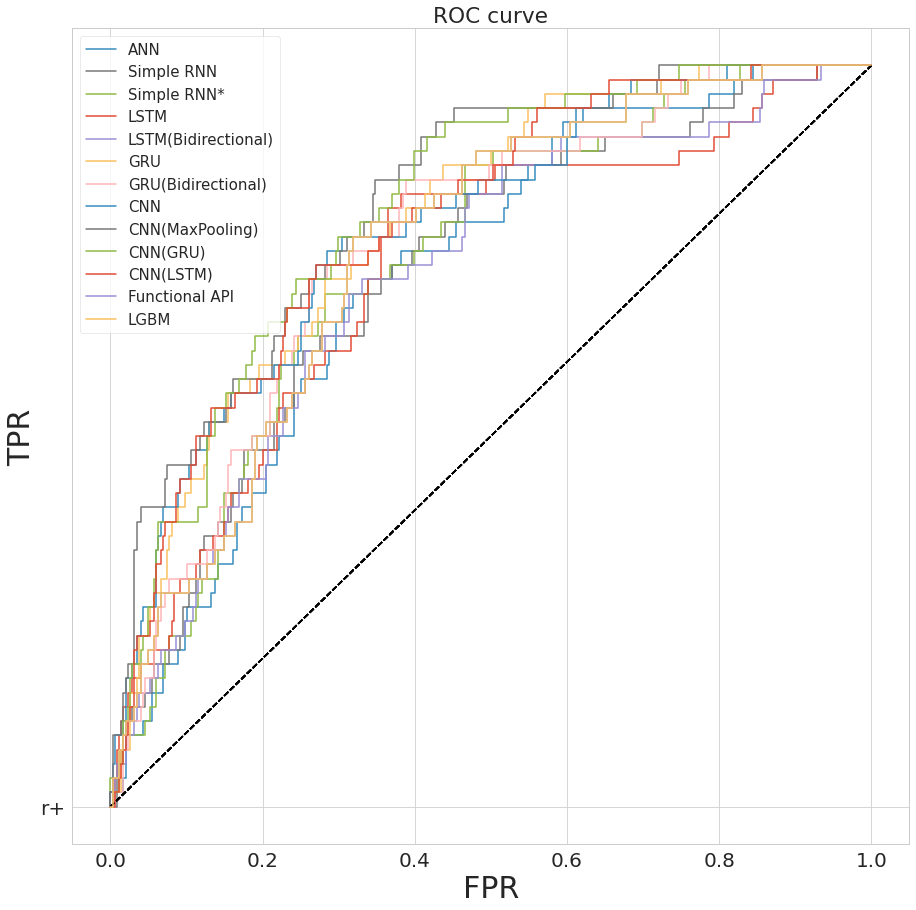

In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,15))

plt.rc('font', size=15)        # 기본 폰트 크기
plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('figure', titlesize=20) # figure title 폰트 크기

loaded_ann_fpr, loaded_ann_tpr, loaded_ann_thresholds = roc_curve(test_y_3d, loaded_ann_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_ann_fpr, loaded_ann_tpr, label='ANN')

loaded_rnn1_fpr, loaded_rnn1_tpr, loaded_rnn1_thresholds = roc_curve(test_y_3d, loaded_rnn1_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_rnn1_fpr, loaded_rnn1_tpr, label='Simple RNN')

loaded_rnn2_fpr, loaded_rnn2_tpr, loaded_rnn2_thresholds = roc_curve(test_y_3d, loaded_rnn2_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_rnn2_fpr, loaded_rnn2_tpr, label='Simple RNN*')

loaded_lstm1_fpr, loaded_lstm1_tpr, loaded_lstm1_thresholds = roc_curve(test_y_3d, loaded_lstm1_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_lstm1_fpr, loaded_lstm1_tpr, label='LSTM')

loaded_lstm2_fpr, loaded_lstm2_tpr, loaded_lstm2_thresholds = roc_curve(test_y_3d, loaded_lstm2_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_lstm2_fpr, loaded_lstm2_tpr, label='LSTM(Bidirectional)')

loaded_gru1_fpr, loaded_gru1_tpr, loaded_gru1_thresholds = roc_curve(test_y_3d, loaded_gru1_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_gru1_fpr, loaded_gru1_tpr, label='GRU')

loaded_gru2_fpr, loaded_gru2_tpr, loaded_gru2_thresholds = roc_curve(test_y_3d, loaded_gru2_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_gru2_fpr, loaded_gru2_tpr, label='GRU(Bidirectional)')

loaded_cnn1_fpr, loaded_cnn1_tpr, loaded_cnn1_thresholds = roc_curve(test_y_3d, loaded_cnn1_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_cnn1_fpr, loaded_cnn1_tpr, label='CNN')

loaded_cnn2_fpr, loaded_cnn2_tpr, loaded_cnn2_thresholds = roc_curve(test_y_3d, loaded_cnn2_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(loaded_cnn2_fpr, loaded_cnn2_tpr, label='CNN(MaxPooling)')

cnn3_fpr, cnn3_tpr, cnn3_thresholds = roc_curve(test_y_3d, cnn3_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(cnn3_fpr, cnn3_tpr, label='CNN(GRU)')

cnn4_fpr, cnn4_tpr, cnn4_thresholds = roc_curve(test_y_3d, cnn4_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(cnn4_fpr, cnn4_tpr, label='CNN(LSTM)')

func_fpr, func_tpr, func_thresholds = roc_curve(test_y_3d, func_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(func_fpr, func_tpr, label='Functional API')

lgbm_fpr, lgbm_tpr, lgbm_thresholds = roc_curve(test_y, lgbm_pred)
plt.plot([0,1], [0,1], "k--", "r+")
plt.plot(func_fpr, func_tpr, label='LGBM')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='upper left')
plt.title('ROC curve')
plt.show()


In [ ]:
# F_positive_rate, T_positive_rate 구하기
ocsvmF_positive_rate, ocsvmT_positive_rate, ocsvm_thresholds =roc_curve(pred_ocsvm, y_test)
isfF_positive_rate, isfT_positive_rate, isv_thresholds =roc_curve(pred_isf, y_test)
xgF_positive_rate, xgT_positive_rate, xg_thresholds =roc_curve(pred_xg, y_test)
 
#roc_auc
ocsvm_roc_auc = auc(ocsvmF_positive_rate, ocsvmT_positive_rate)
isf_roc_auc = auc(isfF_positive_rate, isfT_positive_rate)
xg_roc_auc = auc(xgF_positive_rate, xgT_positive_rate)
 
plt.step(ocsvmF_positive_rate, ocsvmT_positive_rate, color='blue', lw=2)
plt.step(isfF_positive_rate, isfT_positive_rate, color='red', lw=2)
plt.step(xgF_positive_rate, xgT_positive_rate, color='green', lw=2)
 
plt.legend(['ocsvm','isf','xg'])
plt.show()

# **DF 만들기**

In [ ]:
new_final_df = test_df.drop_duplicates(['pid'])
new_final_df = new_final_df.reset_index(drop=True)
new_final_df

,pid,age,Gender,ICUType,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,Na,PaCO2,PaO2,Platelets,RR,SPO2,BT,TroponinI,TroponinT,Urine,WBC,pH,MechVent,SBP,DBP,MBP,label
0,135089,90.0,1.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,0
1,142245,86.0,1.0,2.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,0
2,137989,63.0,0.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,0
3,142184,74.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,0
4,134318,48.0,1.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,139907,39.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,0
396,136230,75.0,1.0,1.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,0
397,139358,71.0,1.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,1
398,137755,81.0,0.0,2.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,0


In [ ]:
l = new_final_df['label']
new_final_df.drop(['label'], axis=1, inplace=True)
new_final_df

,pid,age,Gender,ICUType,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,Na,PaCO2,PaO2,Platelets,RR,SPO2,BT,TroponinI,TroponinT,Urine,WBC,pH,MechVent,SBP,DBP,MBP
0,135089,90.0,1.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0
1,142245,86.0,1.0,2.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0
2,137989,63.0,0.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0
3,142184,74.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0
4,134318,48.0,1.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,139907,39.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0
396,136230,75.0,1.0,1.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0
397,139358,71.0,1.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0
398,137755,81.0,0.0,2.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0


In [ ]:
l

0      0
1      0
2      0
3      0
4      0
      ..
395    0
396    0
397    1
398    0
399    0
Name: label, Length: 400, dtype: int64

In [ ]:
df = pd.DataFrame(loaded_ann_pred, columns=['ann_pred'])
df['rnn1_pred'] = loaded_rnn1_pred
df['rnn2_pred'] = loaded_rnn2_pred
df['lstm1_pred'] = loaded_lstm1_pred
df['lstm2_pred'] = loaded_lstm2_pred
df['gru1_pred'] = loaded_gru1_pred
df['gru2_pred'] = loaded_gru2_pred
df['cnn1_pred'] = loaded_cnn1_pred
df['cnn2_pred'] = loaded_cnn2_pred
df['cnn3_pred'] = cnn3_pred
df['cnn4_pred'] = cnn4_pred
df['func_pred'] = func_pred
df['label'] = l
df

,ann_pred,rnn1_pred,rnn2_pred,lstm1_pred,lstm2_pred,gru1_pred,gru2_pred,cnn1_pred,cnn2_pred,cnn3_pred,cnn4_pred,func_pred,label
0,0.187945,0.194980,0.099230,0.265696,0.162173,0.078263,0.287509,0.181897,0.517276,0.158691,0.130277,0.276604,0
1,0.005038,0.049538,0.022523,0.042383,0.040664,0.061275,0.066394,0.074918,0.074862,0.039546,0.058954,0.122288,0
2,0.101193,0.141326,0.097287,0.137633,0.065726,0.048790,0.134727,0.084252,0.129996,0.046524,0.080675,0.165232,0
3,0.253652,0.159958,0.071077,0.192188,0.120176,0.109736,0.143778,0.096610,0.262353,0.110297,0.118813,0.155400,0
4,0.026324,0.119062,0.097390,0.088058,0.033889,0.021357,0.092776,0.026288,0.059903,0.021399,0.045726,0.110219,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.216977,0.111176,0.042660,0.099051,0.084935,0.053267,0.116202,0.062749,0.222347,0.094937,0.084095,0.068855,0
396,0.059853,0.100568,0.040718,0.105690,0.090938,0.023471,0.086249,0.039083,0.066863,0.028497,0.025484,0.134379,0
397,0.102612,0.143213,0.056455,0.148060,0.099787,0.057153,0.156426,0.095933,0.184970,0.180900,0.069598,0.179712,1
398,0.029120,0.050814,0.033413,0.040923,0.034838,0.032585,0.017325,0.034036,0.180852,0.027978,0.043801,0.038481,0


In [ ]:
new_df = pd.concat([new_final_df, df], axis=1)
new_df

,pid,age,Gender,ICUType,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,Na,PaCO2,PaO2,Platelets,RR,SPO2,BT,TroponinI,TroponinT,Urine,WBC,pH,MechVent,SBP,DBP,MBP,ann_pred,rnn1_pred,rnn2_pred,lstm1_pred,lstm2_pred,gru1_pred,gru2_pred,cnn1_pred,cnn2_pred,cnn3_pred,cnn4_pred,func_pred,label
0,135089,90.0,1.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,0.187945,0.194980,0.099230,0.265696,0.162173,0.078263,0.287509,0.181897,0.517276,0.158691,0.130277,0.276604,0
1,142245,86.0,1.0,2.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,0.005038,0.049538,0.022523,0.042383,0.040664,0.061275,0.066394,0.074918,0.074862,0.039546,0.058954,0.122288,0
2,137989,63.0,0.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,0.101193,0.141326,0.097287,0.137633,0.065726,0.048790,0.134727,0.084252,0.129996,0.046524,0.080675,0.165232,0
3,142184,74.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,0.253652,0.159958,0.071077,0.192188,0.120176,0.109736,0.143778,0.096610,0.262353,0.110297,0.118813,0.155400,0
4,134318,48.0,1.0,3.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,0.026324,0.119062,0.097390,0.088058,0.033889,0.021357,0.092776,0.026288,0.059903,0.021399,0.045726,0.110219,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,139907,39.0,0.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,0.216977,0.111176,0.042660,0.099051,0.084935,0.053267,0.116202,0.062749,0.222347,0.094937,0.084095,0.068855,0
396,136230,75.0,1.0,1.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,0.059853,0.100568,0.040718,0.105690,0.090938,0.023471,0.086249,0.039083,0.066863,0.028497,0.025484,0.134379,0
397,139358,71.0,1.0,4.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,0.102612,0.143213,0.056455,0.148060,0.099787,0.057153,0.156426,0.095933,0.184970,0.180900,0.069598,0.179712,1
398,137755,81.0,0.0,2.0,85.0,45.0,72.0,2.9,20.0,0.8,143.5,1.0,0.5,14.0,127.0,23.0,30.4,86.0,4.0,2.0,2.0,139.0,40.0,118.0,170.5,19.0,97.0,37.1,2.6,0.18,75.0,11.0,7.38,1.0,116.0,58.0,77.0,0.029120,0.050814,0.033413,0.040923,0.034838,0.032585,0.017325,0.034036,0.180852,0.027978,0.043801,0.038481,0


In [ ]:
new_df.to_csv('/content/drive/MyDrive/최종프로젝트/EDA_data.csv')

In [ ]:
roc_auc_score(new_df['label'], new_df['cnn2_pred'])

0.8162577365163571

In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve

plt.figure(figsize=(15,15))

plt.rc('font', size=15)        # 기본 폰트 크기
plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('figure', titlesize=20) # figure title 폰트 크기

for i in new_df.columns:
    fpr, tpr, thresholds = roc_curve(test_y, new_df[new_df[i]])
    plt.plot([0,1], [0,1], "k--", "r+")
    plt.plot(fpr, tpr, label=i)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='upper left')
plt.title('ROC curve')
plt.show()

# **EDA**

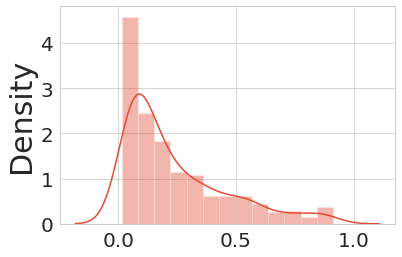

In [ ]:
import seaborn as sns

sns.distplot(new_df['cnn2_pred'].values)

In [ ]:
loaded_cnn2_thresholds

array([1.9140958 , 0.91409576, 0.9033571 , 0.87988245, 0.8508601 ,
       0.8322059 , 0.83157665, 0.80392057, 0.77468324, 0.7596698 ,
       0.75643086, 0.7500442 , 0.73213404, 0.6440288 , 0.6057768 ,
       0.59466755, 0.5943301 , 0.5905735 , 0.5504732 , 0.5352285 ,
       0.53056043, 0.5294031 , 0.48554713, 0.48031643, 0.4597913 ,
       0.4588544 , 0.45214254, 0.44886717, 0.40875453, 0.4081141 ,
       0.39931548, 0.39856595, 0.39740843, 0.38558722, 0.33878568,
       0.33593652, 0.33579883, 0.33360347, 0.31844163, 0.31577492,
       0.29183733, 0.29025334, 0.2796962 , 0.27712116, 0.2623528 ,
       0.26145807, 0.24324395, 0.23958783, 0.23393631, 0.2333351 ,
       0.21833853, 0.21725318, 0.21042371, 0.2091492 , 0.20338842,
       0.20039982, 0.18608373, 0.18497   , 0.17634311, 0.17442353,
       0.16755292, 0.16695024, 0.1552217 , 0.152147  , 0.08011732,
       0.07971624, 0.07248132, 0.07178455, 0.07170057, 0.07121582,
       0.01362895], dtype=float32)

In [ ]:
loaded_cnn2_thresholds[loaded_cnn2_fpr > 0.8]

array([0.01362895], dtype=float32)

In [ ]:
loaded_cnn2_thresholds[(loaded_cnn2_tpr>0.9) & (loaded_cnn2_fpr>0.9)]

array([0.01362895], dtype=float32)

In [ ]:
loaded_cnn2_fpr, loaded_cnn2_tpr, loaded_cnn2_thresholds = roc_curve(test_y_3d, loaded_cnn2_pred)
loaded_cnn2_roc_auc = roc_auc_score(test_y_3d, loaded_cnn2_pred)
